In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [12]:
def montage(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    m = np.ones((images.shape[1] * n_plots + n_plots + 1, images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [20]:
mnist = input_data.read_data_sets('MNIST_data')
tf.reset_default_graph()
batch_size = 64
n_latent = 100

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
noise = tf.placeholder(dtype=tf.float32, shape=[None, n_latent])

keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
is_training = tf.placeholder(dtype=tf.bool, name='is_training')

def lrelu(x):
    return tf.maximum(x, tf.multiply(x, 0.2))

def binary_cross_entropy(z, x):
    eps = 1e-12
    return (-(x * tf.log(z + eps) + (1. - x) * tf.log(1. - z + eps)))

def discriminator(img_in, reuse=None, keep_prob=keep_prob):
    activation = lrelu
    with tf.variable_scope("discriminator", reuse=reuse):
        x = tf.reshape(img_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, kernel_size=5, filters=64, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=128, activation=activation)
        x = tf.layers.dense(x, units=1, activation=tf.nn.sigmoid)
        return x
    
def generator(z, keep_prob=keep_prob, is_training=is_training):
    activation = lrelu
    momentum = 0.99
    with tf.variable_scope("generator", reuse=None):
        x = tf.layers.dense(z, units=49, activation=activation)
        x = tf.reshape(x, shape=[-1, 7, 7, 1])
        x = tf.layers.conv2d_transpose(x, kernel_size=4, filters=64, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=32, strides=2, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=16, strides=1, padding='same', activation=activation)
        x = tf.layers.dropout(x, keep_prob)
        x = tf.contrib.layers.batch_norm(x, is_training=is_training, decay=momentum)
        x = tf.layers.conv2d_transpose(x, kernel_size=5, filters=1, strides=1, padding='same', activation=tf.nn.sigmoid)
        return x    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
g = generator(noise, keep_prob, is_training)
d_real = discriminator(X_in)
d_fake = discriminator(g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]


d_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
g_reg = tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)

loss_d_real = binary_cross_entropy(tf.ones_like(d_real), d_real)
loss_d_fake = binary_cross_entropy(tf.zeros_like(d_fake), d_fake)
loss_g = tf.reduce_mean(binary_cross_entropy(tf.ones_like(d_fake), d_fake))

loss_d = tf.reduce_mean(0.5 * (loss_d_real + loss_d_fake))

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_d + d_reg, var_list=vars_d)
    optimizer_g = tf.train.RMSPropOptimizer(learning_rate=0.0002).minimize(loss_g + g_reg, var_list=vars_g)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

(0, 13.764416, 13.934891, 13.832701, 13.696131)


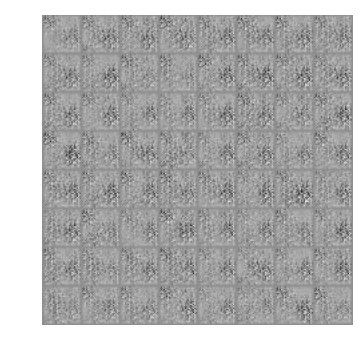

(50, 2.6916828, 27.561153, 5.3134956, 0.069869705)
not training discriminator


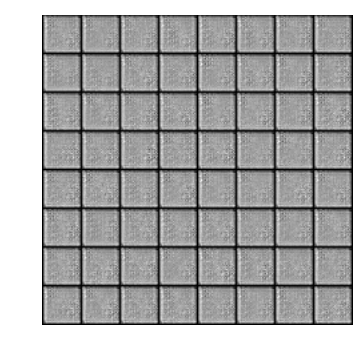

(100, 8.547802, 27.62397, 17.088552, 0.0070515061)
not training generator


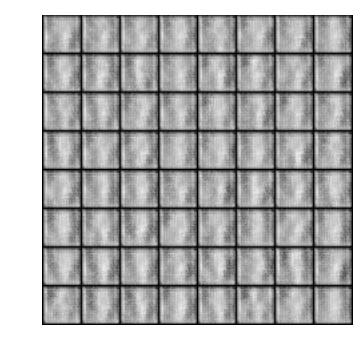

(150, 5.8615904, 26.848234, 10.940392, 0.7827884)


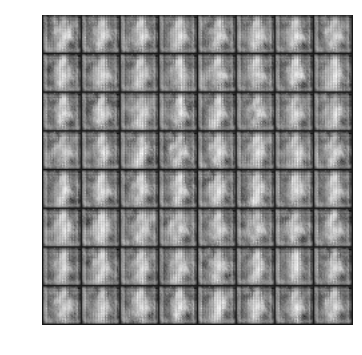

(200, 9.6568947, 27.230843, 18.91361, 0.40017915)
not training discriminator


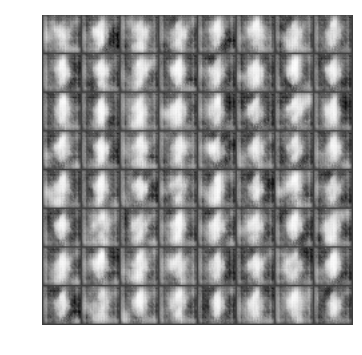

(250, 7.5499773, 27.383844, 14.852777, 0.24717736)
not training discriminator


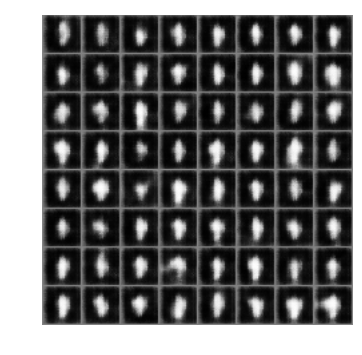

(300, 8.0741425, 27.576735, 16.093998, 0.054286908)
not training discriminator


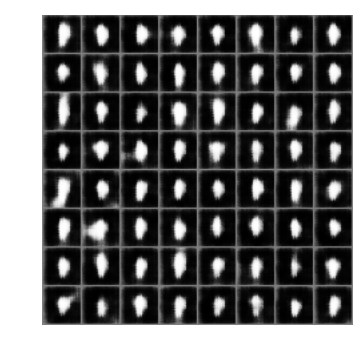

(350, 4.0474739, 19.631342, 0.095268264, 7.9996791)
not training generator


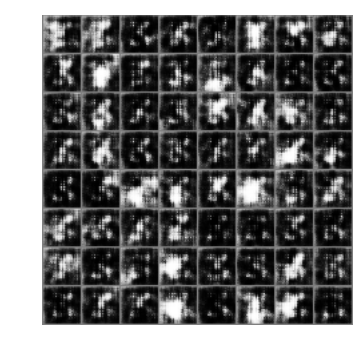

(400, 3.1556406, 22.795395, 1.475656, 4.8356247)


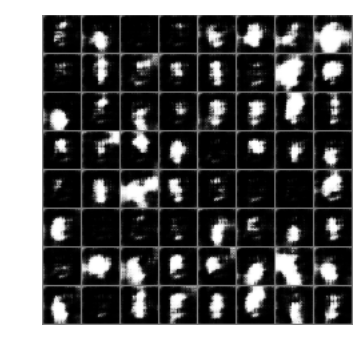

(450, 3.2147205, 23.462093, 2.2605114, 4.1689296)


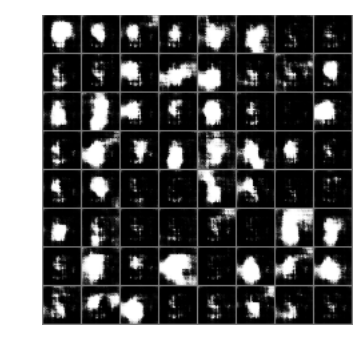

(500, 5.4911776, 16.702263, 0.053597718, 10.928758)
not training generator


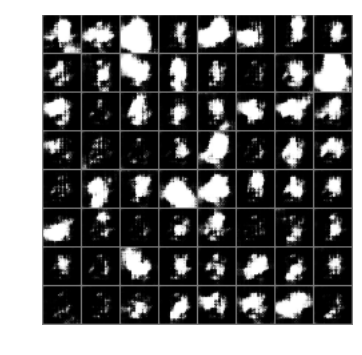

(550, 2.4688342, 27.133835, 4.4404812, 0.49718696)


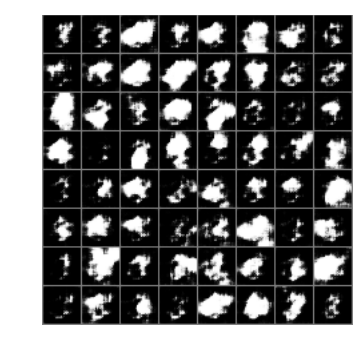

(600, 4.227448, 19.364113, 0.18798837, 8.2669086)
not training generator


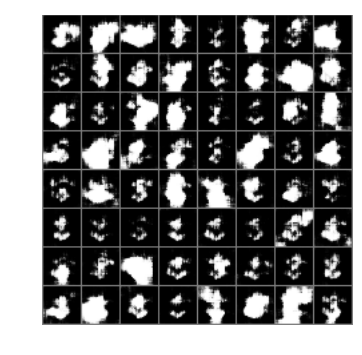

(650, 1.7262692, 26.480511, 2.3020289, 1.1505096)


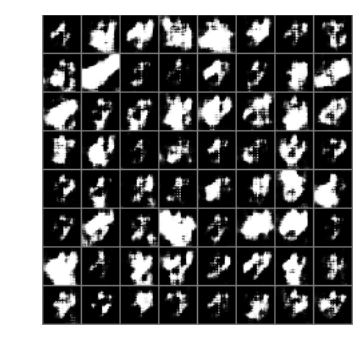

(700, 8.4018497, 27.320137, 16.492817, 0.31088361)
not training discriminator


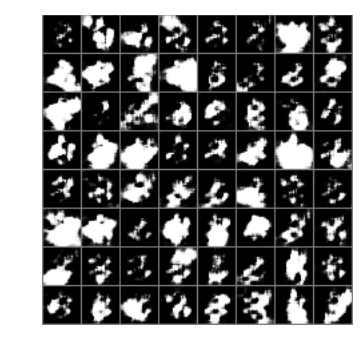

(750, 6.835979, 13.970741, 0.011678946, 13.660279)
not training generator


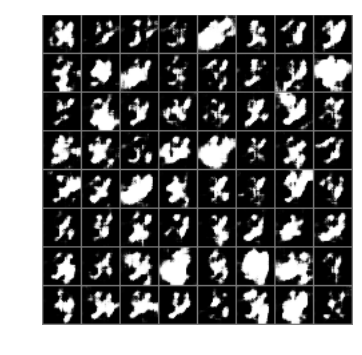

(800, 3.0253072, 27.46843, 5.8880229, 0.16259149)
not training discriminator


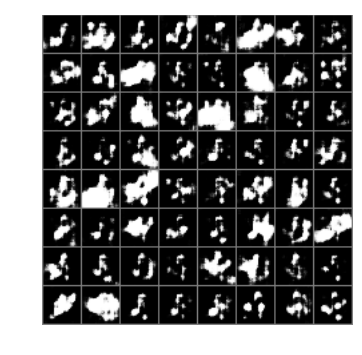

(850, 2.7554336, 22.392624, 0.2724703, 5.2383966)


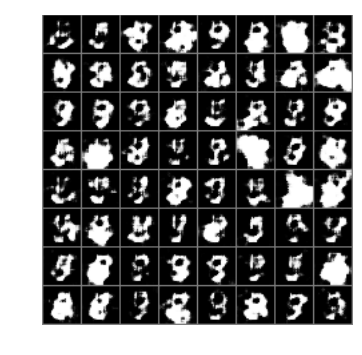

(900, 4.6982908, 27.561853, 9.3274126, 0.069168493)
not training discriminator


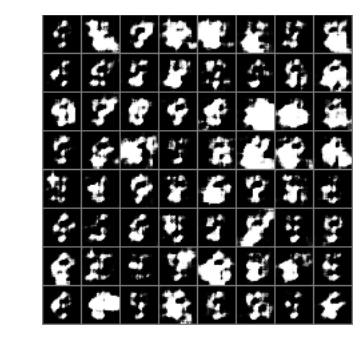

(950, 6.9584866, 13.87326, 0.15921187, 13.757761)
not training generator


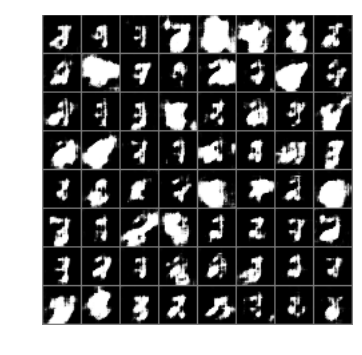

(1000, 5.4291945, 16.818197, 0.045564532, 10.812825)
not training generator


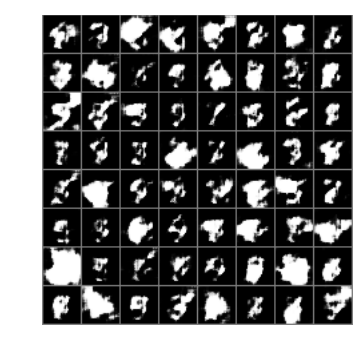

(1050, 4.3821669, 19.006224, 0.13953611, 8.6247978)
not training generator


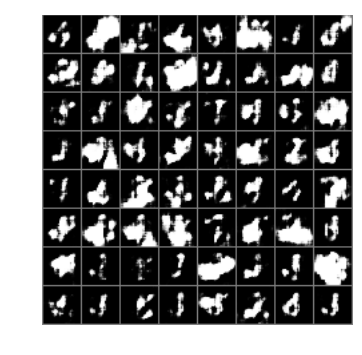

(1100, 3.4236422, 20.869287, 0.085549712, 6.761734)
not training generator


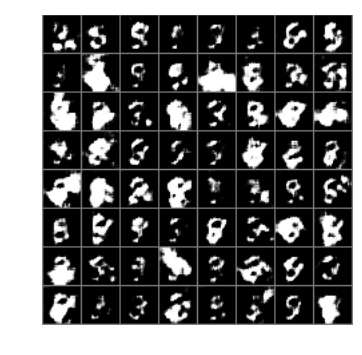

(1150, 3.3644907, 27.603458, 6.7014179, 0.027563455)
not training discriminator


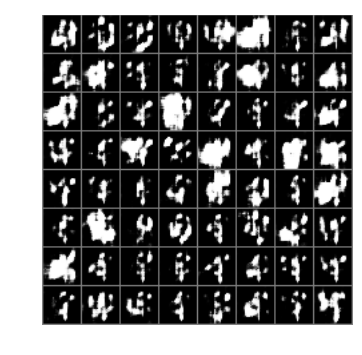

(1200, 4.2208662, 27.583363, 8.3940735, 0.047659434)
not training discriminator


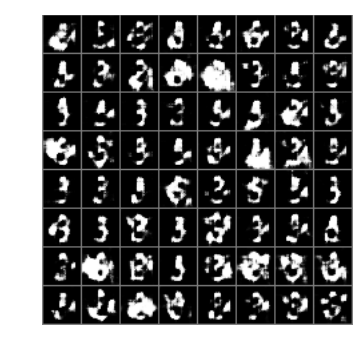

(1250, 4.4289336, 27.613518, 8.8403606, 0.017506221)
not training discriminator


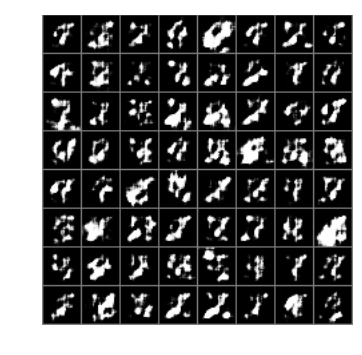

(1300, 5.433672, 17.086348, 0.32267031, 10.544674)
not training generator


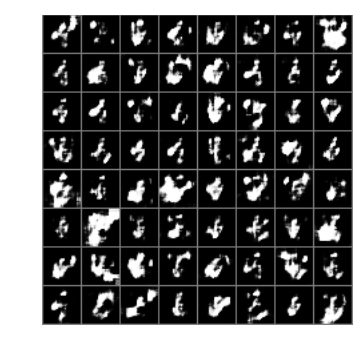

(1350, 4.4026937, 21.776489, 2.9508553, 5.8545332)


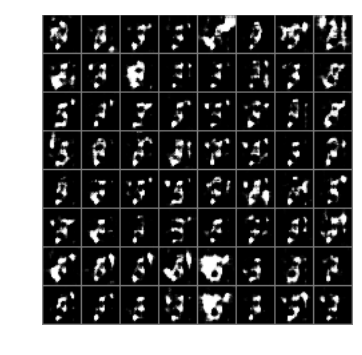

(1400, 2.481389, 24.264381, 1.5961368, 3.3666415)


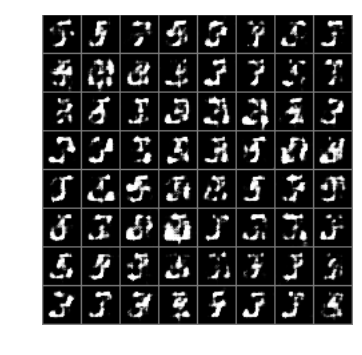

(1450, 7.7588153, 27.619621, 15.506229, 0.011402179)
not training discriminator


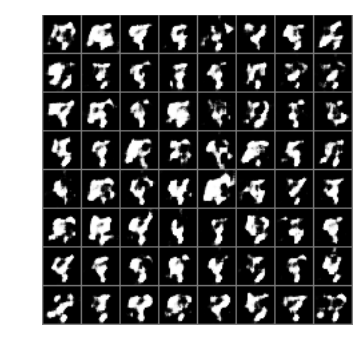

(1500, 2.8724074, 27.590221, 5.7040138, 0.04080113)
not training discriminator


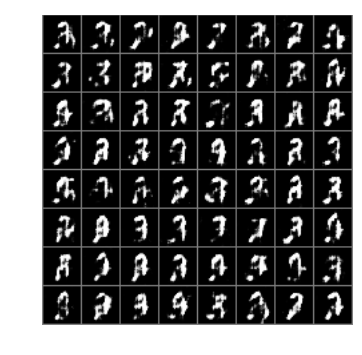

(1550, 5.803308, 27.629114, 11.60471, 0.0019072143)
not training generator


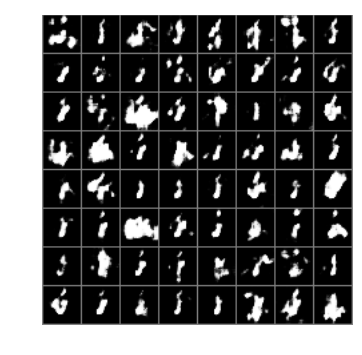

(1600, 8.812788, 27.463993, 17.458548, 0.16702831)
not training discriminator


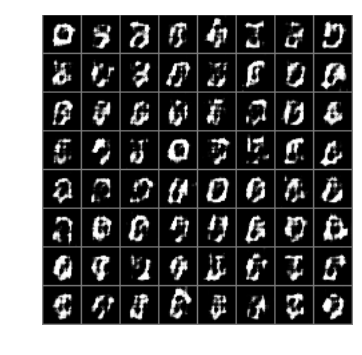

(1650, 2.5047712, 24.222281, 1.6008011, 3.4087415)


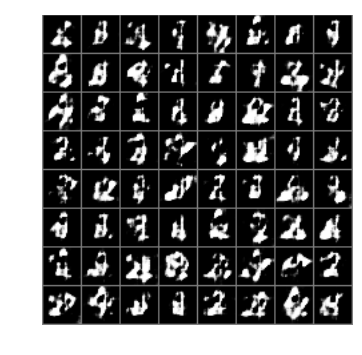

(1700, 6.056931, 27.488464, 11.971304, 0.14255825)
not training discriminator


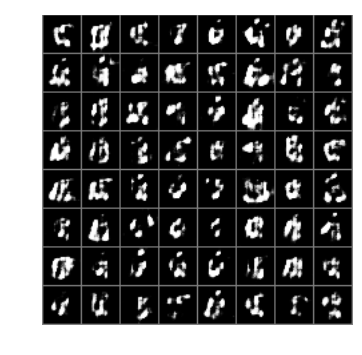

(1750, 6.3967376, 16.305616, 1.4680699, 11.325405)


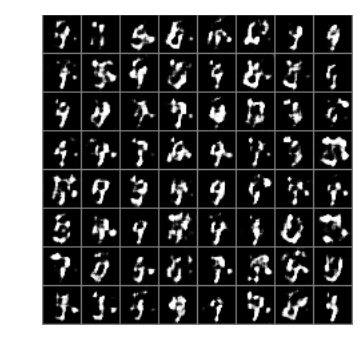

(1800, 5.5983739, 27.3111, 10.876825, 0.3199228)
not training discriminator


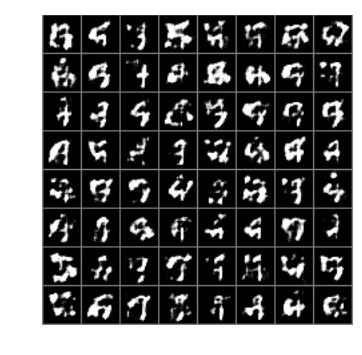

(1850, 3.7824316, 27.252874, 7.1867166, 0.37814656)


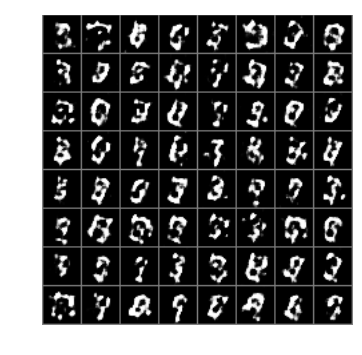

(1900, 6.5144238, 26.608265, 12.006092, 1.0227567)


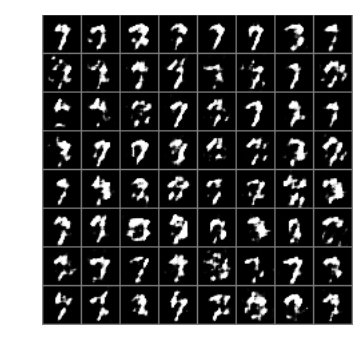

(1950, 5.6478195, 26.863087, 10.527704, 0.76793504)


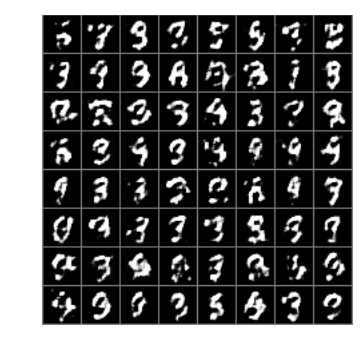

(2000, 2.8820906, 21.995859, 0.12901707, 5.6351638)
not training generator


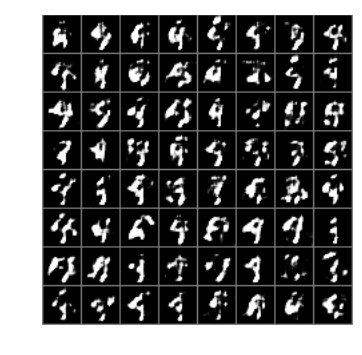

(2050, 4.9443188, 27.465824, 9.7234411, 0.16519621)
not training discriminator


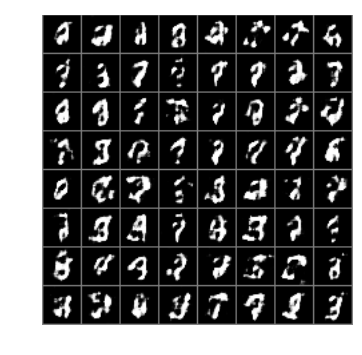

(2100, 4.6274867, 27.620605, 9.2445564, 0.010416711)
not training discriminator


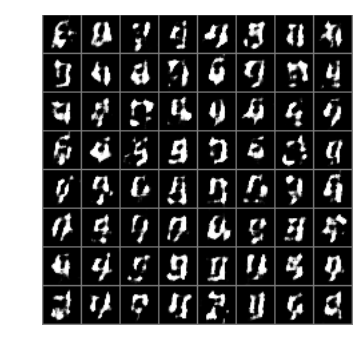

(2150, 4.7857285, 18.205357, 0.14579174, 9.4256649)
not training generator


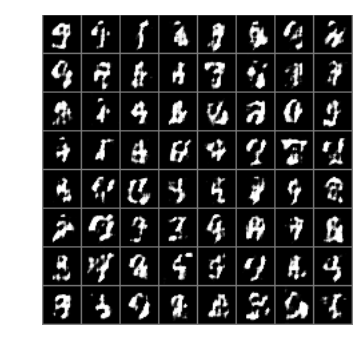

(2200, 6.0612197, 27.60968, 12.101096, 0.021342233)
not training discriminator


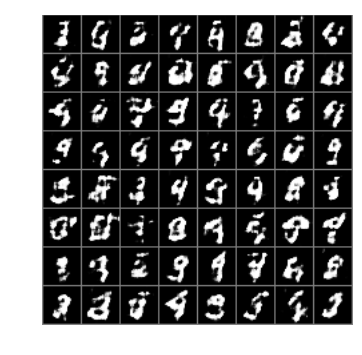

(2250, 2.1546352, 25.203386, 1.8816371, 2.4276333)


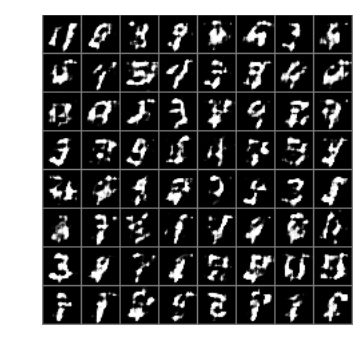

(2300, 2.0562298, 26.830891, 3.3123279, 0.80013204)


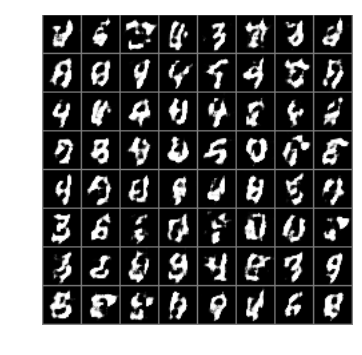

(2350, 1.605432, 25.619915, 1.1997581, 2.011106)


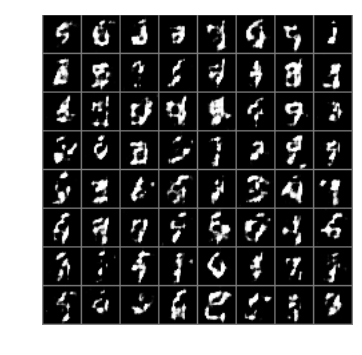

(2400, 3.1656742, 27.345892, 6.0462189, 0.28512987)
not training discriminator


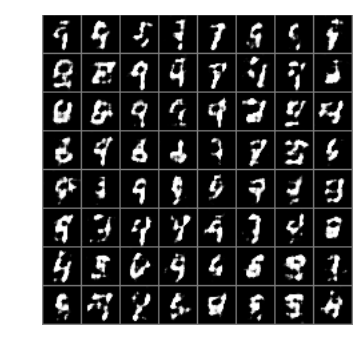

(2450, 4.2435832, 27.504345, 8.3604908, 0.12667622)
not training discriminator


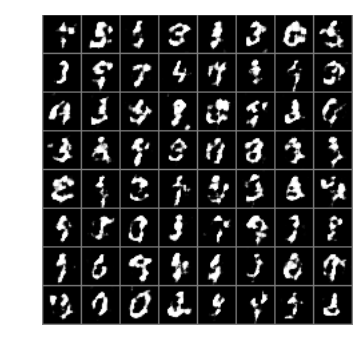

(2500, 2.1713321, 24.409941, 1.1215836, 3.2210808)


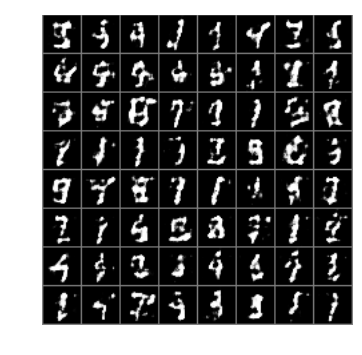

In [ ]:
for i in range(30000):
    train_d = True
    train_g = True
    keep_prob_train = 0.5 # 0.6
    
    
    n = np.random.uniform(0.0, 1.0, [batch_size, n_latent]).astype(np.float32)   
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]  
    
    d_real_ls, d_fake_ls, g_ls, d_ls = sess.run([loss_d_real, loss_d_fake, loss_g, loss_d], feed_dict={X_in: batch, noise: n, keep_prob: keep_prob_train, is_training:True})
    
    d_real_ls = np.mean(d_real_ls)
    d_fake_ls = np.mean(d_fake_ls)
    g_ls = g_ls
    d_ls = d_ls
    
    
    
    
    if d_fake_ls < 0.01 or d_real_ls * 20 < d_fake_ls:
        train_g = False
        pass
    elif d_real_ls < 0.01 or d_fake_ls * 20 < d_real_ls:
        train_d = False
        pass
    
    
   
    
    if train_d:
        sess.run(optimizer_d, feed_dict={noise: n, X_in: batch, keep_prob: keep_prob_train, is_training:True})
        
        
    if train_g:
        sess.run(optimizer_g, feed_dict={noise: n, keep_prob: keep_prob_train, is_training:True})
        
        
    if not i % 50:
        print (i, d_ls, g_ls, d_real_ls, d_fake_ls)
        if not train_g:
            print("not training generator")
        if not train_d:
            print("not training discriminator")
        gen_img = sess.run(g, feed_dict = {noise: n, keep_prob: 1.0, is_training:False})
        imgs = [img[:,:,0] for img in gen_img]
        m = montage(imgs)
        gen_img = m
        plt.axis('off')
        plt.imshow(gen_img, cmap='gray')
        plt.show()